## Baseline Model - RNN with complete backpropagation
- Using a RNN with 2 linear layers , with LogSoftMax as activation function. 
- Performing classification on the Digits dataset from sklearn.
- Results measured in logg loss (sum) and accuracy. 

Code (inspiration) I used :
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627 
- Especially a lot of the code on github: https://github.com/jmtomczak/intro_dgm 

Errors i ran in to:
- https://nieznanm.medium.com/runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-85d0d207623



In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary

### The Digits Dataset:

In [2]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)
    

In [3]:
# Initiliazing the data loaders for the digits dataset. 

train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

LABELS = train_data.target_names

train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

result_dir = 'results_baseline_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)


447


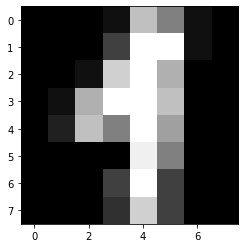

In [4]:
# Print an example digit and its according target label. - (digits dataset)

print(len(test_data.targets))
plottable_image = np.reshape(train_data.data[90], (8, 8))
plt.imshow(plottable_image, cmap='gray')

### The MNIST dataset

In [5]:
class MNIST(Dataset):
    """Complete MNIST dataset."""

    def __init__(self, mode='train', transforms=None):
        data_set_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

        data_set_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
        self.data = []
        self.targets = []
        
        if mode == 'train':
            for i in range(50000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        elif mode == 'val':
            for i in range(50000, 60000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        else:
            for i in range(len(data_set_test)):
                self.data.append(data_set_test[i][0].numpy())
                self.targets.append(data_set_test[i][1])
        
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [6]:
# Load in the MNIST dataset - (takes longer to load than Digits!, 6)
train_data_mnist = MNIST(mode='train')
val_data_mnist = MNIST(mode='val')
test_data_mnist = MNIST(mode='test')

train_loader_mnist = DataLoader(train_data_mnist, batch_size=50, shuffle=True)
val_loader_mnist = DataLoader(val_data_mnist, batch_size=50, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=50, shuffle=False)

1


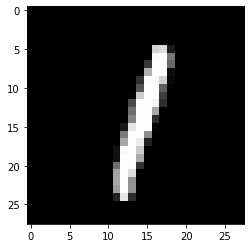

In [7]:
# Print an example MNIST digit and its according target label. - (digits dataset)

print(val_data_mnist.targets[1900])
plottable_image = np.reshape(val_data_mnist.data[1900], (28, 28))
plt.imshow(plottable_image, cmap='gray')

### The Baseline RNN 

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dataset_MNIST = False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.mnist = dataset_MNIST

    def forward(self, input, hidden):
        
        # If we use the Digits dataset
        if self.mnist == False:
            if input.size()[0] != 50:
                # Adjust the hidden state to make it fit with a batch that is not equal to 50:
                hidden_adj = torch.narrow(hidden, 0, (50-1-input.size()[0]), input.size()[0])
                combined = torch.cat((input, hidden_adj), 1)  
            else:
                combined = torch.cat((input, hidden), 1)  
        
        # If we use the MNIST dataset - squeeze the MNIST Tensor in 2 dimensions 
        elif self.mnist == True:
            three_d_tensor = input.squeeze(1)
            two_d_tensor = three_d_tensor.contiguous().view(three_d_tensor.size()[0], -1)  # 28 * 28 pixels = 784
            combined = torch.cat((two_d_tensor, hidden), 1)
        
    
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output2 = self.softmax(output)
        return output2, hidden
        

    def initHidden(self):
        return torch.zeros(50, self.hidden_size)


## Auxilary functions

In [9]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]


# Plot both accuracy as log loss. 
def plot_results(epochs, loss, accuracy):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Results RNN - Full Backpropagation.')
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    ax1.plot(epochs, loss)
    ax2.plot(epochs, accuracy)
    

    plt.savefig('results_rnn_baseline.png', bbox_inches='tight')
    #plt.close()


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    hidden = model.initHidden()
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initliaze dataset size and loss
    loss = 0.
    N = 0.
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        
        output, hidden = model.forward(batch, hidden)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [31]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0
    t = 0 
    
    # Initialize hidden layers
    
    # Used for error detection
    #torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):
        # Training
        
        # Initialize hidden layers
        hidden = model.initHidden()
        model.train()
        
        # Processing batch by batch
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output, hidden = model.forward(batch, hidden)
            
            targets = targets.long()
            
            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
        #Perform back prop after each epoch
        # Previously: Inplace error because of the mini-batch gradient descent approach, now only
        # backpropagate after every epoch. 
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()   

        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)
        
        if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_baseline.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_baseline.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1
        
        # If loss has not improved for an arbitrary amount of epochs:
        if loss_iter > max_loss_iter:
            break
    
    plot_results(epochs, loss_results, accuracy_results)
    
    return model



## Parameter set-up

In [32]:
INPUT_SIZE_DIGITS = 64  # 8 * 8 pixels
INPUT_SIZE_MNIST = 784  # 28 * 28 pixels
BATCH_SIZE = 50 
n_hidden = 128
n_labels = 10
n_epochs = 100
lr_SGD = 0.0006
momentum_SGD = 0.9
max_loss_iter = 5

## Initialize model/optimizer/loss_function. Start training.

Training started for 100 epochs.
Epoch: 0 - Loss of: 0.08877949919019426 - Accuracy of: 18.285715103149414
* Saving 1st epoch model *
Epoch: 1 - Loss of: 0.07715490818023682 - Accuracy of: 18.571428298950195
* Saving new best model *
Epoch: 2 - Loss of: 0.06838749544961112 - Accuracy of: 17.14285659790039
* Saving new best model *
Epoch: 3 - Loss of: 0.06372488975524902 - Accuracy of: 16.285715103149414
* Saving new best model *
Epoch: 4 - Loss of: 0.06229929651532854 - Accuracy of: 15.714285850524902
* Saving new best model *
Epoch: 5 - Loss of: 0.06310299805232457 - Accuracy of: 16.285715103149414
Epoch: 6 - Loss of: 0.06336990969521658 - Accuracy of: 16.85714340209961
Epoch: 7 - Loss of: 0.060693915230887276 - Accuracy of: 17.14285659790039
* Saving new best model *
Epoch: 8 - Loss of: 0.0563122204371861 - Accuracy of: 19.428571701049805
* Saving new best model *
Epoch: 9 - Loss of: 0.051126958983285085 - Accuracy of: 24.571428298950195
* Saving new best model *
Epoch: 10 - Loss of:

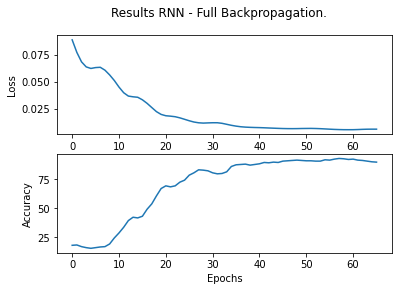

In [33]:
# Perform training on the DIGITS dataset
model = RNN(INPUT_SIZE_DIGITS, n_hidden, n_labels, dataset_MNIST = False)
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='mean') # Mean is also possible.

trained_model = training(model, train_loader, val_loader, n_epochs, optimizer, loss_function, max_loss_iter)


Training started for 100 epochs.
Epoch: 0 - Loss of: 0.05091530528068543 - Accuracy of: 13.289999961853027
* Saving 1st epoch model *
Epoch: 1 - Loss of: 0.05086814997196198 - Accuracy of: 13.470000267028809
* Saving new best model *
Epoch: 2 - Loss of: 0.050889301013946536 - Accuracy of: 13.039999961853027
Epoch: 3 - Loss of: 0.050912002420425415 - Accuracy of: 13.270000457763672
Epoch: 4 - Loss of: 0.05092198524475098 - Accuracy of: 13.239999771118164
Epoch: 5 - Loss of: 0.050913992738723754 - Accuracy of: 13.25
Epoch: 6 - Loss of: 0.05086750576496124 - Accuracy of: 13.09000015258789
* Saving new best model *
Epoch: 7 - Loss of: 0.05088652963638306 - Accuracy of: 13.3100004196167
Epoch: 8 - Loss of: 0.05090632276535034 - Accuracy of: 13.380000114440918
Epoch: 9 - Loss of: 0.05093614201545715 - Accuracy of: 13.050000190734863
Epoch: 10 - Loss of: 0.05090410087108612 - Accuracy of: 13.550000190734863
Epoch: 11 - Loss of: 0.05090516796112061 - Accuracy of: 13.25
Epoch: 12 - Loss of: 0.0

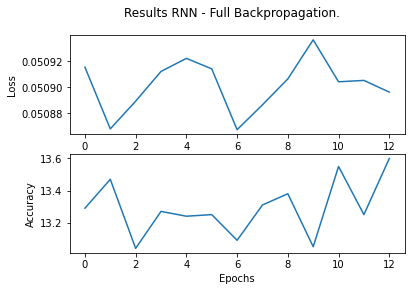

In [27]:
# Perform training on the MNIST dataset
model_mnist = RNN(INPUT_SIZE_MNIST, n_hidden, n_labels, dataset_MNIST = True)
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad == True], lr=0.5, momentum=0.9)
loss_function_mnist = nn.NLLLoss(reduction='mean') # Mean is also possible.

trained_model_mnist = training(model_mnist, train_loader_mnist, val_loader_mnist, n_epochs, optimizer, loss_function_mnist, max_loss_iter)

In [28]:
# Summary of the RNN model:
print(summary(model, torch.zeros(50, 64), model.initHidden(), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [50, 192]          24,704          24,704
          Linear-2           [50, 192]           1,930           1,930
      LogSoftmax-3            [50, 10]               0               0
Total params: 26,634
Trainable params: 26,634
Non-trainable params: 0
-----------------------------------------------------------------------


## Analyze our performance on the test set:

In [29]:
test_result = evaluation(test_loader, trained_model, 'Final score', loss_function)

Epoch: Final score - Loss of: 0.010213840594494369 - Accuracy of: 86.57717895507812


In [30]:
test_result_mnist = evaluation(test_loader_mnist, trained_model_mnist, 'Final score', loss_function_mnist)

Epoch: Final score - Loss of: 0.0506149258852005 - Accuracy of: 14.140000343322754
